In [19]:
import re
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Exploratory Data Analysis (EDA)

In this chapter, I will explore the dataset used to train a company classification model.  

The goal is to better understand the structure of the data, the distribution of industry tags and the characteristics of the text descriptions provided for each company.

This analysis will help guide future preprocessing and modeling decisions.


### Step 1: Load and Inspect the Dataset

I started by loading the Excel file containing labeled company descriptions and their industry tags.  

The goal is to verify the structure, column names, and potential issues before further processing.


In [20]:
companies = pd.read_excel("data\Training_Data_Set_for_Data_Science_Case_Study.xlsx")
companies.head(5)

,Company Name,Business Description,Industry Classification Tag
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising


In [21]:
print(companies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6045 entries, 0 to 6044
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Company Name                 6045 non-null   object
 1   Business Description         6022 non-null   object
 2   Industry Classification Tag  6045 non-null   object
dtypes: object(3)
memory usage: 141.8+ KB
None


### Step 2: Handle Missing and Duplicate Values

I checked the dataset for missing values and duplicates.
  
Entries without a description or label were removed to ensure clean and usable data.


In [22]:
print(companies.isnull().sum())

Company Name                    0
Business Description           23
Industry Classification Tag     0
dtype: int64


In [23]:
# Because there are only 23 rows with no description out of 6045 we will drop those.
companies = companies.dropna(subset=["Business Description"])
companies["Business Description"].isna().value_counts()

Business Description
False    6022
Name: count, dtype: int64

In [24]:
print(f"Found {companies.duplicated().sum()} duplicate entries. Dropping them now.")
companies = companies.drop_duplicates()

Found 50 duplicate entries. Dropping them now.


In [25]:
# We don't need the company name so I'll ignore that column
companies = companies[["Business Description", "Industry Classification Tag"]]
companies.head(3)

,Business Description,Industry Classification Tag
0,"Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corporation provides online marketing...,Advertising


In [26]:
companies = companies.rename(columns={
    "Business Description": "company_description",
    "Industry Classification Tag": "tags"
})
companies.head(3)

,company_description,tags
0,"Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corporation provides online marketing...,Advertising


### Step 3: Industry Tag Overview

There are 62 unique industry tags in the dataset.  
Below is a chart showing the most common tags and their frequency.

In [27]:
print('Total number of tags: ', len(companies['tags'].unique()))

Total number of tags:  62


C:\Users\andreea\AppData\Local\Temp\ipykernel_20892\2417054195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="pastel")


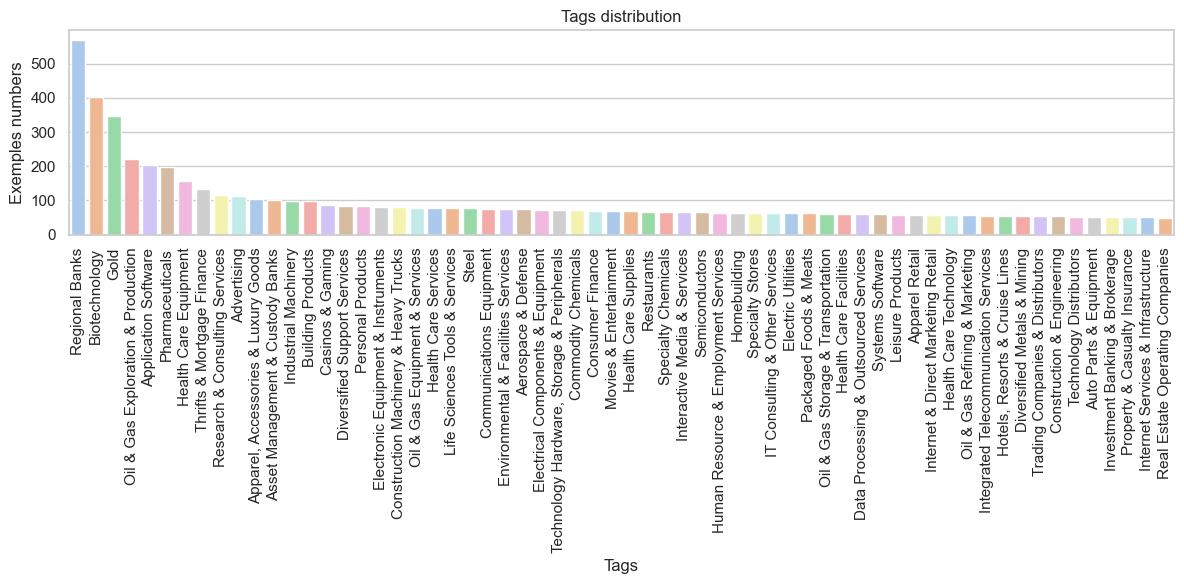

In [28]:
tag_counts = companies['tags'].value_counts()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="pastel")

plt.xticks(rotation=90)
plt.xlabel("Tags")
plt.ylabel("Exemples numbers")
plt.title("Tags distribution")

plt.tight_layout()
plt.show()


 We can observe that the most frequent categories include:

- **Regional Banks**
- **Biotechnology**
- **Gold**
- **Oil & Gas Exploration & Production**
- **Application Software**

In total, there are **64 unique industry tags**, covering a diverse range of business sectors.


### Step 4: Analyze Average Description Length per Tag

I calculated the number of words in each company description to understand how detailed the text is for each industry category.


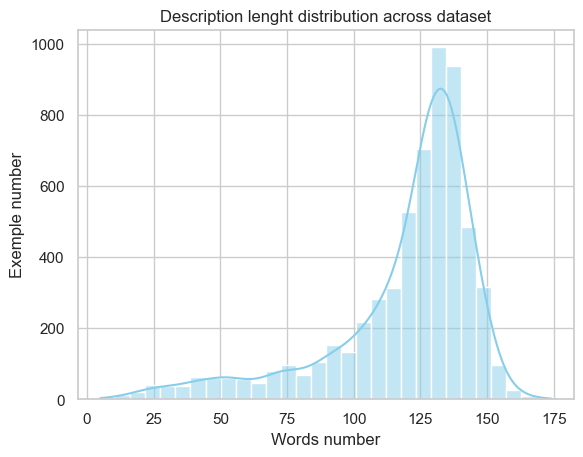

In [29]:
companies['desc_len'] = companies['company_description'].apply(lambda x: len(str(x).split()))
sns.histplot(companies['desc_len'], bins=30, kde=True, color="skyblue")
plt.title("Description lenght distribution across dataset")
plt.xlabel("Words number")
plt.ylabel("Exemple number")
plt.show()

In [30]:
pd.set_option('display.max_colwidth', None)
companies[companies['desc_len'] < 10]

,company_description,tags,desc_len
1277,GoldBlue AB publ is a Sweden-based investment company.,Casinos & Gaming,8
2896,Â Â Audio equipment manufacturer.,Health Care Technology,5
3625,Fountaine Pajot SA manufactures cruising catamarans.,Leisure Products,6
5831,Matica Fintec SpA is an Italy-based financial technology company.,"Technology Hardware, Storage & Peripherals",9


I initially considered removing descriptions with fewer than 10 words, assuming they might be too vague or uninformative.

However, after manual inspection, I found that many of these short texts still provide relevant and specific information about the company's activity, sector, or business type.

Therefore, I decided to **keep all entries**, even those with a description length below 10 words.

C:\Users\andreea\AppData\Local\Temp\ipykernel_20892\3199872698.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_len_per_tag.index, y=avg_len_per_tag.values, palette='pastel')


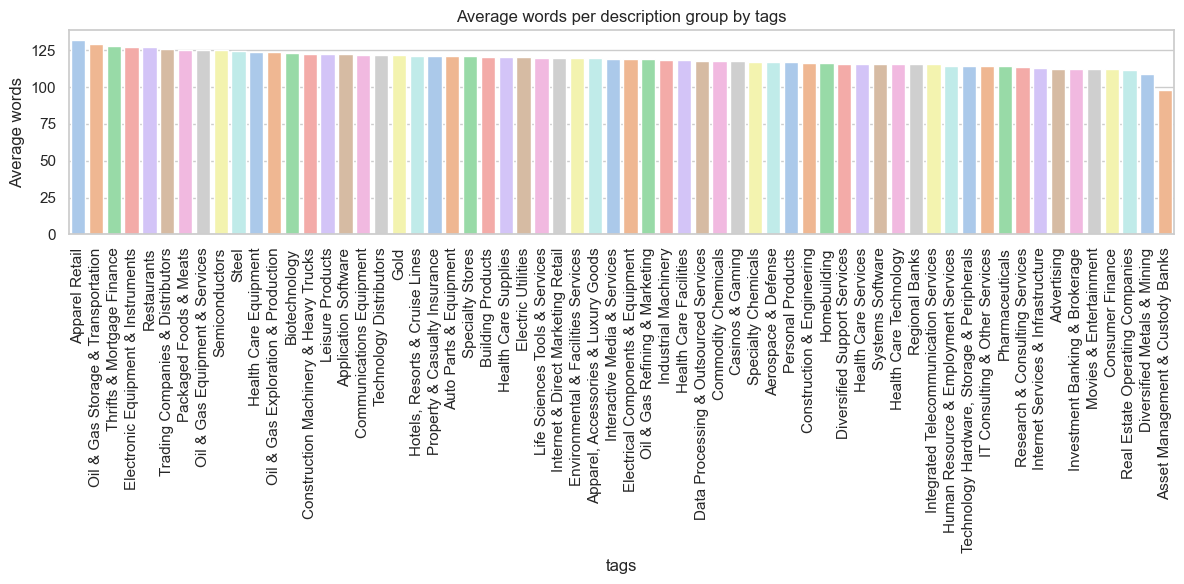

In [31]:
# Average descriprion lenght acording to tags
avg_len_per_tag = companies.groupby('tags')['desc_len'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_len_per_tag.index, y=avg_len_per_tag.values, palette='pastel')
plt.xticks(rotation=90)
plt.ylabel("Average words")
plt.title("Average words per description group by tags")
plt.tight_layout()
plt.show()


For each industry tag, I calculated the average length of company descriptions   to check if any tags were associated with poorly described or uninformative entries.

The results showed that the average description length per tag ranged between **100 and 125 words**, which indicates a consistent level of textual detail across all categories.

A good starting point for training a text classification model.

# Formatting the Data for FastText

In this chapter, I prepared the data for training with **FastText**, which expects a specific input format. 

Text normalization is essential to ensure consistency — I converted all text to **lowercase**, removed special characters, and stripped extra whitespace.

I selected the `companies["tags"]` column as the **label** for classification.  

The `company_description` column will serve as the **textual input** for the model.




### Label Grouping and Data Formatting for FastText

The original dataset contained a large number of fine-grained industry tags, many of which had very few samples. To ensure the classification model has enough data per label, 
I grouped similar tags into broader categories using a custom mapping (`label_map`).

This reduced the number of unique labels while preserving the semantic meaning of each class.  

The new grouped labels were saved in a new column called `tag_grouped`.

In [32]:
label_map = {
    "Advertising & Media": [
        "Advertising", "Interactive Media & Services", "Movies & Entertainment"
    ],
    "Aerospace & Defense": ["Aerospace & Defense"],
    "Apparel & Retail": [
        "Apparel Retail", "Apparel, Accessories & Luxury Goods",
        "Internet & Direct Marketing Retail", "Specialty Stores"
    ],
    "Software & IT Services": [
        "Application Software", "Systems Software",
        "IT Consulting & Other Services", "Technology Distributors"
    ],
    "Hardware & Components": [
        "Technology Hardware, Storage & Peripherals", "Electronic Equipment & Instruments",
        "Electrical Components & Equipment", "Communications Equipment", "Semiconductors"
    ],
    "Healthcare & Pharma": [
        "Health Care Equipment", "Health Care Facilities", "Health Care Services",
        "Health Care Supplies", "Health Care Technology", "Pharmaceuticals",
        "Life Sciences Tools & Services"
    ],
    "Oil & Gas": [
        "Oil & Gas Equipment & Services", "Oil & Gas Exploration & Production",
        "Oil & Gas Refining & Marketing", "Oil & Gas Storage & Transportation"
    ],
    "Construction & Building": [
        "Building Products", "Homebuilding", "Construction & Engineering",
        "Construction Machinery & Heavy Trucks"
    ],
    "Food, Restaurants & Leisure": [
        "Restaurants", "Packaged Foods & Meats", "Leisure Products"
    ],
    "Financial Services": [
        "Regional Banks", "Asset Management & Custody Banks",
        "Consumer Finance", "Investment Banking & Brokerage",
        "Thrifts & Mortgage Finance"
    ],
    "Industrial & Materials": [
        "Industrial Machinery", "Diversified Metals & Mining", "Commodity Chemicals",
        "Specialty Chemicals", "Steel", "Auto Parts & Equipment", "Personal Products"
    ],
    "Professional & Business Services": [
        "Human Resource & Employment Services", "Research & Consulting Services",
        "Consulting Services", "Diversified Support Services",
        "Data Processing & Outsourced Services"
    ],
    "Utilities & Infrastructure": [
        "Electric Utilities", "Environmental & Facilities Services",
        "Internet Services & Infrastructure", "Real Estate Operating Companies"
    ],
    "Insurance & Real Estate": ["Property & Casualty Insurance"],
    "Hospitality & Travel": ["Hotels, Resorts & Cruise Lines"]
}


In [33]:
tag_to_group = {}
for group, tags in label_map.items():
    for tag in tags:
        tag_to_group[tag] = group

In [34]:
companies['tags_grouped'] = companies['tags'].apply(lambda x: tag_to_group.get(x, x))

In [35]:
print(companies[['tags', 'tags_grouped']].drop_duplicates().sort_values('tags_grouped'))

                                     tags                      tags_grouped
0                             Advertising               Advertising & Media
3717               Movies & Entertainment               Advertising & Media
3292         Interactive Media & Services               Advertising & Media
113                   Aerospace & Defense               Aerospace & Defense
187                        Apparel Retail                  Apparel & Retail
...                                   ...                               ...
5992     Trading Companies & Distributors  Trading Companies & Distributors
3414   Internet Services & Infrastructure        Utilities & Infrastructure
2077  Environmental & Facilities Services        Utilities & Infrastructure
1860                   Electric Utilities        Utilities & Infrastructure
4598      Real Estate Operating Companies        Utilities & Infrastructure

[62 rows x 2 columns]


### Text and Label Normalization

To prepare the data for FastText, I applied the following preprocessing steps:

- **Lowercased** all text fields
- **Removed special characters**
- **Replaced whitespace in labels** with underscores
- **Prefixed** each label with `__label__` as required by FastText

In [36]:
def ColumnNormalization(df, column): 
    df.loc[:, column] = df[column].str.replace(r'[^a-zA-Z0-9\s\']', '', regex = True).str.lower()
    df.loc[:, column] = df[column].str.replace(r'\s+', ' ',regex = True)
    df.loc[:, column] = df[column].fillna("")
        
    stop_words = set(stopwords.words("english"))
    df.loc[:, column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return df

In [37]:
companies['labels'] = companies['tags_grouped']
companies = ColumnNormalization(companies, "company_description")
companies = ColumnNormalization(companies, "labels")
companies_labels = companies.drop(columns="desc_len")
companies_labels.head(3)

,company_description,tags,tags_grouped,labels
0,adsouth partners inc provides advertising agency services specializing direct response media campaigns also owns distribution rights number products acquired business consists two operating sectors advertising products year ended december 31 2005 internally developed marketed two lines flashlights branded extreme beam flashlight clip light company obtained exclusive fiveyear marketing distribution rights hercules hook distribution rights dshed pearlanti wrinkle moisturizing mist 2005 2005 company also organized genco power solutions inc genco purpose marketing selling installing servicing integrated power generator systems residential homeowners commercial business throughout florida company owns 66 genco,Advertising,Advertising & Media,advertising media
1,artec global media inc formerly artec consulting corp marketing firm company provides online marketing reporting solutions including lead generation performance media affiliate marketing related web services consultation segments include online marketing media services owns accesses targeted databases utilizes technology create local regional national marketing campaigns demand providing clients ability acquire new customers runs advertisements forms marketing messages programs multiple channels email direct mail social media short message service sms radio telecommunication create responders client offerings marketing services include affiliate performance marketing display advertising email marketing lead generation creative design consulting services also engaged student loan debt consultation business,Advertising,Advertising & Media,advertising media
2,betawave corporation provides online marketing solutions websites targeting youth moms company specializes aggregating distributing marketing content selected network targeted sites mostly virtual worlds gaming gofish exclusive brand advertising monetization partner gofish provides services planning buying execution ad campaigns gofish also provides online videos targeting teen audience,Advertising,Advertising & Media,advertising media


In [38]:
def LabelColumns(df, column):
    df[column] = df[column].str.replace(r"\s+", "_", regex=True)
    df.loc[pd.notna(df[column]) & (df[column] != ""), column] = "__label__" + df[column]
    return df

In [39]:
companies = LabelColumns(companies_labels, 'labels')

In [40]:
companies["labels_text"] = companies["labels"] + " " + companies["company_description"] 

In [41]:
companies["labels_text"].iloc[0]

'__label__advertising_media adsouth partners inc provides advertising agency services specializing direct response media campaigns also owns distribution rights number products acquired business consists two operating sectors advertising products year ended december 31 2005 internally developed marketed two lines flashlights branded extreme beam flashlight clip light company obtained exclusive fiveyear marketing distribution rights hercules hook distribution rights dshed pearlanti wrinkle moisturizing mist 2005 2005 company also organized genco power solutions inc genco purpose marketing selling installing servicing integrated power generator systems residential homeowners commercial business throughout florida company owns 66 genco'

## Label Dictionary and Export

To ensure traceability between the FastText-formatted labels and the original industry names, I created a dictionary (`label_dict`) that maps each `__label__...` format to its corresponding original category.

This mapping is useful for interpreting model predictions and visualizing results in a human-readable form.

I also saved all the processed labels to a separate file (`all_labels.csv`)  
for later use in model evaluation and error analysis.

In [42]:
all_labels = companies[["labels"]]
all_labels.to_csv("data/all_labels.csv", index=False)

In [43]:
label_to_tag = companies[["labels", "tags_grouped"]].drop_duplicates().set_index("labels")["tags_grouped"].to_dict()
label_to_tag

{'__label__advertising_media': 'Advertising & Media',
 '__label__aerospace_defense': 'Aerospace & Defense',
 '__label__apparel_retail': 'Apparel & Retail',
 '__label__software_services': 'Software & IT Services',
 '__label__financial_services': 'Financial Services',
 '__label__industrial_materials': 'Industrial & Materials',
 '__label__biotechnology': 'Biotechnology',
 '__label__construction_building': 'Construction & Building',
 '__label__casinos_gaming': 'Casinos & Gaming',
 '__label__hardware_components': 'Hardware & Components',
 '__label__professional_business_services': 'Professional & Business Services',
 '__label__utilities_infrastructure': 'Utilities & Infrastructure',
 '__label__gold': 'Gold',
 '__label__healthcare_pharma': 'Healthcare & Pharma',
 '__label__hospitality_travel': 'Hospitality & Travel',
 '__label__integrated_telecommunication_services': 'Integrated Telecommunication Services',
 '__label__food_restaurants_leisure': 'Food, Restaurants & Leisure',
 '__label__oil_g

In [44]:
with open("data/label_to_tag.json", "w", encoding="utf-8") as f:
    json.dump(label_to_tag, f, ensure_ascii=False, indent=2)

In [45]:
companies_lables = companies["labels_text"]

## Splitting the Dataset

To prepare for model training and evaluation, I split the dataset in two steps:

1. **Train/Test Split**  
   - 80% of the data is used for training  
   - 20% is reserved for testing the model's final performance  
   - The split is **stratified by `tag_grouped`**, to maintain class balance across splits

2. **Train/Validation Split**  
   - From the training set, I further split 10% into a validation set  
   - This validation set is used during training to monitor performance and prevent overfitting

This results in:
- **72%** train  
- **8%** validation  
- **20%** test

Stratification ensures that the distribution of industry tags is consistent across all three subsets.


In [46]:
sector_column = companies['tags_grouped']
data = companies_lables

train_data, test_data, train_sector_column, test_sector_column = train_test_split(
    data, sector_column, test_size=0.2, stratify=sector_column, random_state=42)

In [47]:
print(f"Training data: {train_data.shape[0]} rows")
print(f"Testing data: {test_data.shape[0]} rows")

Training data: 4777 rows
Testing data: 1195 rows


C:\Users\andreea\AppData\Local\Temp\ipykernel_20892\642622739.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="pastel")


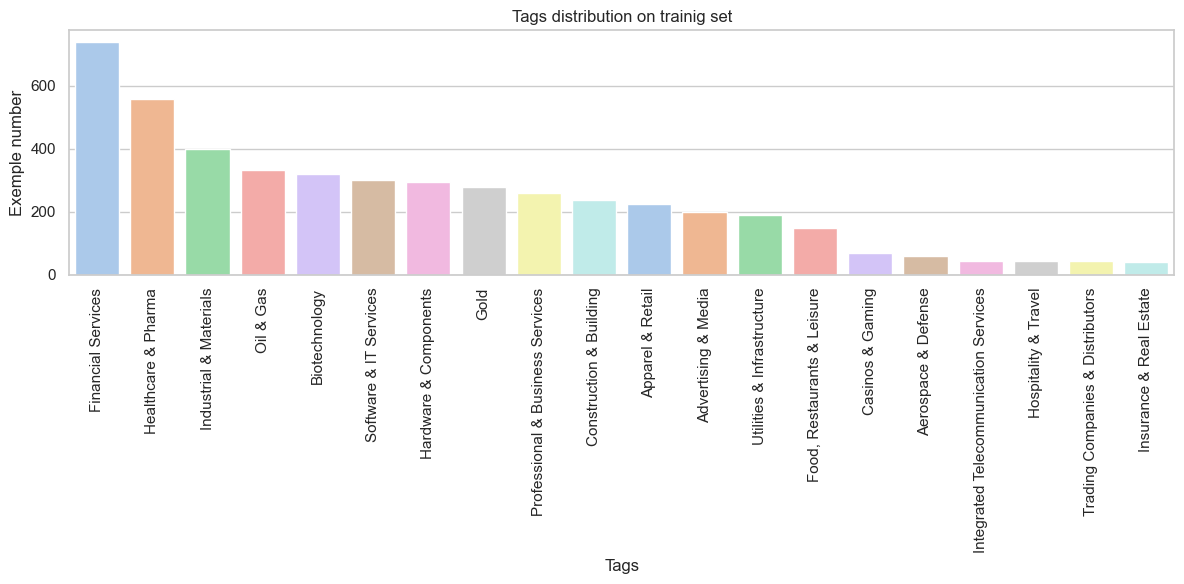

In [48]:
tag_counts = train_sector_column.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="pastel")

plt.xticks(rotation=90)
plt.xlabel("Tags")
plt.ylabel("Exemple number")
plt.title("Tags distribution on trainig set")
plt.tight_layout()
plt.show()

In [49]:
test_data.to_csv("data/test_data.txt", index=False, header=False, sep='\t')

In [50]:
new_train_data, val_data, new_train_sector_column, val_sector_column = train_test_split(
    train_data, train_sector_column, test_size=0.1, stratify=train_sector_column, random_state=42)

In [51]:
print(f"Training data: {new_train_data.shape[0]} rows")
print(f"Validation data: {val_data.shape[0]} rows")

Training data: 4299 rows
Validation data: 478 rows


In [52]:
new_train_data.to_csv("data/train_data.txt", index=False, header=False, sep='\t')
val_data.to_csv("data/val_data.txt", index=False, header=False, sep='\t')